In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/HW4/lfw.zip', 'r') as zip_ref:
    zip_ref.extractall('')
path = 'lfw'

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [13]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA")
else:
    print("No CUDA found")
    device = torch.device("cpu")

CUDA


In [15]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

torch.Size([250, 250, 3])


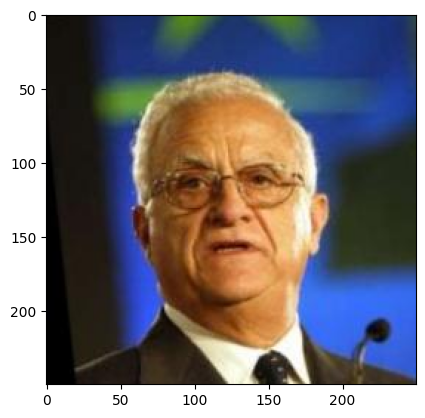

In [16]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

**Autoencoders (AEs):**


*   Application: Compression, denoising, feature learning.
*   Architecture: Encoder produces a deterministic latent representation.
*   Loss Function: Reconstruction loss (e.g., MSE or BCE).

**Variational Autoencoders (VAEs):**



*   Application: Data synthesis, image generation, style transfer.
*   Architecture: Encoder outputs mean and log variance, introduces a sampling step.
*   Loss Function: Reconstruction loss + KL divergence loss.





# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dims=32):  # Adjust latent_dims to get the desired output shape
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.5)  # Add a dropout layer with a dropout probability of 0.5
        )
        self.fc_mu = nn.Linear(128 * 16 * 16, latent_dims)
        self.fc_logvar = nn.Linear(128 * 16 * 16, latent_dims)

        # Decoder
        self.decoder_input = nn.Linear(latent_dims, 128 * 16 * 16)

        # Adjust the decoder to output an image of size [3, 250, 250]
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        h1 = self.encoder(x)
        h1 = h1.view(h1.size(0), -1)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def decode(self, z):
        h3 = self.decoder_input(z)
        h3 = h3.view(h3.size(0), 128, 16, 16)  # Reshape to match the input shape of the decoder
        return self.decoder(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

1.**Passing through the model**:
Firstly, I created an instance of the VAE and pass an example image through the model to obtain the reconstructed output (output_image), mean (mu), and log variance (logvar) from the encoder.

2.**Shape of Encoder Output**:
Then, print the shape of the output of the encoder, which consists of the mean (mu) and log variance (logvar). This output represents the parameters of the distribution in the latent space.

3.**Generating new samples in the latent space**:
After that I use the reparameterize function to generate new samples in the latent space based on the mean and log variance obtained from the encoder.

4.**Using the decoder to generate new images**:
Then I pass the generated latent samples through the decoder to create new images (generated_images).

Finally, I print the shapes of the original image, reconstructed image, and generated images to verify that the forward pass is working correctly. The VAE is expected to reconstruct the input image and generate new images from the latent space.

In [27]:
# Instantiate the VAE model
model = VAE().to(device)
for images, _ in dataloader:
    images = images.to(device)

    # Forward pass through the model
    output_image, mu, logvar = model(images)

    # Reparameterize to get latent space samples
    latent_samples = model.reparameterize(mu, logvar)

    # Use the decoder to create new images from the latent samples
    generated_images = model.decode(latent_samples)

    # Print the shape of the output of the encoder
    print("Shape of Encoder Output (mu):", mu.shape)
    print("Shape of Encoder Output (logvar):", logvar.shape)

    # Print the shape of the output of the decoder
    print("Shape of Decoder Output (Generated Images):", generated_images.shape)

    # Verify that the forward pass is working correctly
    print("Original Image Shape:", images.shape)
    print("Shape of output_image images:", output_image.shape)

    break



Shape of Encoder Output (mu): torch.Size([32, 32])
Shape of Encoder Output (logvar): torch.Size([32, 32])
Shape of Decoder Output (Generated Images): torch.Size([32, 3, 250, 250])
Original Image Shape: torch.Size([32, 3, 250, 250])
Shape of output_image images: torch.Size([32, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

The loss function for a VAE consists of two main terms:
   

**1.   Reconstruction loss(BCELoss)**


*   **Goal**: This term encourages the model to generate reconstructions that are close to the original input.

*   **Explanation**: The reconstruction loss measures the difference between the input image and its reconstruction. In a VAE, Binary Cross Entropy (BCE) loss is commonly used for image data.


**2.   KL divergence loss**

*   **Goal**: This term regularizes the latent space by encouraging it to follow a specific distribution (usually a standard normal distribution).
*   **Explanation**: The KL divergence loss measures the difference between the distribution of the encoded latent variables and a predefined distribution (typically a standard normal distribution).


**Total Loss=Reconstruction Loss+KL Divergence Loss**

The Reconstruction Loss ensures that the VAE can generate images that are faithful reconstructions of the input and The KL Divergence Loss encourages the latent space to be structured and follows a specific distribution, promoting meaningful representations.




In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters.')

#optimizer
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

The model has 3,728,899 trainable parameters.


In [11]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

1. **Learning Rate:** Adjust the learning rate to find a balance between convergence speed and stability.
2. **Model Complexity**: Increase model complexity if it's too simple to capture the data's intricacies.
3. **Data Quality**: Inspect data for outliers, preprocessing errors, and ensure quality.
4. **Loss Function Choice**: Check and validate the chosen loss functions and their parameters.
5. **Regularization**: Apply regularization techniques like weight decay to prevent overfitting.
6. **Latent Space Exploration**: Monitor and ensure meaningful, diverse representations in the latent space.
7. **Code Bugs**: Debug code for errors in model architecture, loss computation, or data handling.

In [12]:
# Number of epochs
num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)

        # Reset gradients
        optim.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data)

        # Compute loss
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backward pass and optimize
        loss.backward()
        optim.step()

        total_loss += loss.item()

    # Average loss for this epoch
    epoch_loss = total_loss / len(dataloader.dataset)

    # Print the epoch summary
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Loss: {epoch_loss:.4f}")

# Training complete
print("Training finished!")


Epoch [1/100], Loss: 104070.5968
Epoch [2/100], Loss: 97053.9380
Epoch [3/100], Loss: 96398.6830
Epoch [4/100], Loss: 96114.7273
Epoch [5/100], Loss: 95933.4734
Epoch [6/100], Loss: 95732.4000
Epoch [7/100], Loss: 95316.7783
Epoch [8/100], Loss: 95138.2356
Epoch [9/100], Loss: 95036.1337
Epoch [10/100], Loss: 94934.1185
Epoch [11/100], Loss: 94866.8999
Epoch [12/100], Loss: 94792.9367
Epoch [13/100], Loss: 94734.1334
Epoch [14/100], Loss: 94665.9147
Epoch [15/100], Loss: 94631.3604
Epoch [16/100], Loss: 94569.3843
Epoch [17/100], Loss: 94525.0595
Epoch [18/100], Loss: 94486.5470
Epoch [19/100], Loss: 94437.3313
Epoch [20/100], Loss: 94402.1262
Epoch [21/100], Loss: 94369.0491
Epoch [22/100], Loss: 94332.4468
Epoch [23/100], Loss: 94291.7608
Epoch [24/100], Loss: 94259.6853
Epoch [25/100], Loss: 94228.8130
Epoch [26/100], Loss: 94191.3932
Epoch [27/100], Loss: 94155.3870
Epoch [28/100], Loss: 94150.9544
Epoch [29/100], Loss: 94106.0833
Epoch [30/100], Loss: 94069.9048
Epoch [31/100], Lo

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

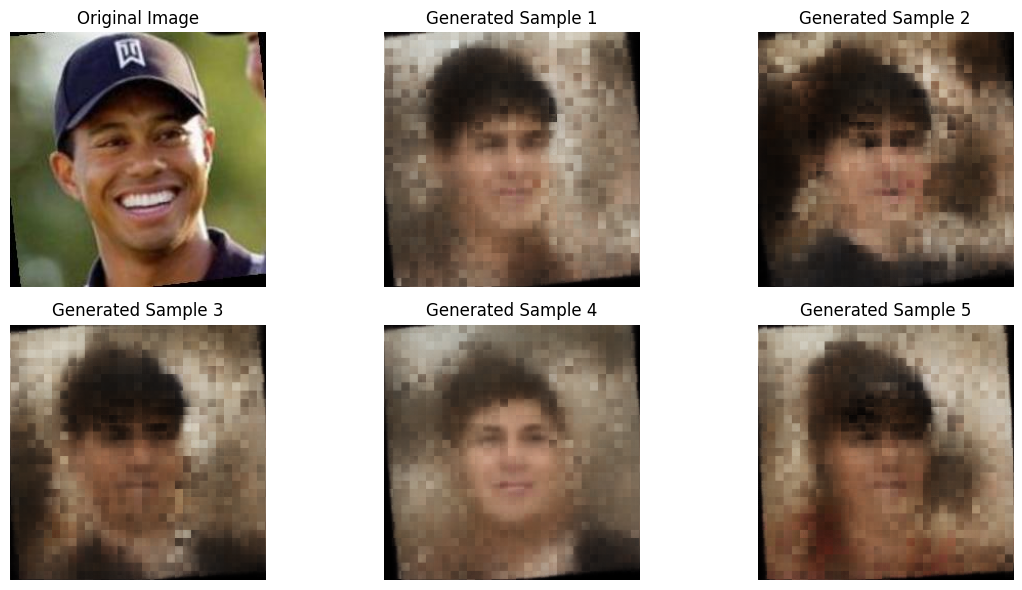

In [13]:
import torch
import torchvision
import matplotlib.pyplot as plt
import random

# Set VAE to evaluation mode
model.eval()

# Select a random image from the dataset
with torch.no_grad():
    data, _ = next(iter(dataloader))
    random_index = random.randint(0, data.size(0) - 1)
    original_image = data[random_index].unsqueeze(0).to(device)  # Add batch dimension

    # Encode the image to get the latent space representation
    mu, logvar = model.encode(original_image)

    # Reparameterize to sample from the latent space
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = model.reparameterize(mu, logvar)

    # Generate and plot 5 additional samples
    with torch.no_grad():
        plt.figure(figsize=(12, 6))

        # Plot the original image
        plt.subplot(2, 3, 1)
        plt.imshow(original_image.cpu().squeeze().permute(1, 2, 0))
        plt.title("Original Image")
        plt.axis('off')

        # Plot generated samples
        for i in range(2, 7):
            # Introduce variation
            z_varied = z + torch.randn_like(z) * 0.5  # Increase the variation factor

            # Decode the varied latent vector
            generated_image_varied = model.decode(z_varied)

            # Plotting
            plt.subplot(2, 3, i)
            plt.imshow(generated_image_varied.cpu().squeeze().permute(1, 2, 0))
            plt.title(f"Generated Sample {i-1}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()
